In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm

# preparo il dataframe con i prezzi di MSFT e S&P500
tickers = ["MSFT", "^GSPC"]

# raw.columns è un MultiIndex con livello 0 = Price, livello 1 = Ticker
raw = yf.download(tickers, start="2020-01-01", end="2023-08-31", interval="1mo")
if raw is None or raw.empty:
    raise ValueError("Download fallito: dati mancanti.")

# prendo il sotto-DataFrame al livello 'Close' => data.columns = Index(['MSFT', '^GSPC'])
data = raw.xs("Close", level="Price", axis=1)

# rendimenti mensili percentuali
rMSFT = data["MSFT"].pct_change().dropna()
rMKT = data["^GSPC"].pct_change().dropna()

# (facoltativo) allineo per sicurezza
rMSFT, rMKT = rMSFT.align(rMKT, join="inner")

# qui servirebbe il risk-free mensile 'rf' con lo stesso index
# per ora faccio vedere la regressione senza rf: Y = dipendente, X = costante+mercato
Y = rMSFT
X = sm.add_constant(rMKT)

# regressione OLS
model = sm.OLS(Y, X).fit()
print(model.summary())

/tmp/ipykernel_5073/1911203972.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers, start="2020-01-01", end="2023-08-31", interval="1mo")
[*********************100%***********************]  2 of 2 completed

                            OLS Regression Results                            
Dep. Variable:                   MSFT   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     53.59
Date:                Mon, 08 Dec 2025   Prob (F-statistic):           5.83e-09
Time:                        20:50:30   Log-Likelihood:                 72.964
No. Observations:                  43   AIC:                            -141.9
Df Residuals:                      41   BIC:                            -138.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0099      0.007      1.415      0.1

In [2]:
import statsmodels.api as sm

# aggiungo il risk-free rate mensile
rf = pd.Series(0.002, index=rMKT.index)  # 0.2% mensile costante

# suppongo di avere rf mensile con lo stesso index di rMSFT e rMKT
rMSFTe = rMSFT - rf
rMKTe = rMKT - rf

# preparo Y e X per la regressione con excess returns: Y = dipendente, X = costante+mercato
Y = rMSFTe
X = sm.add_constant(rMKTe)

# regressione OLS con excess returns
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     53.59
Date:                Mon, 08 Dec 2025   Prob (F-statistic):           5.83e-09
Time:                        20:50:30   Log-Likelihood:                 72.964
No. Observations:                  43   AIC:                            -141.9
Df Residuals:                      41   BIC:                            -138.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0097      0.007      1.391      0.1

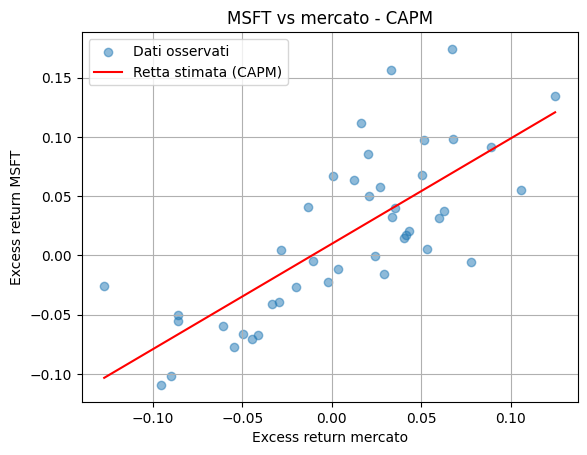

In [ ]:
import matplotlib.pyplot as plt

# 1. prendo alfa e beta per POSIZIONE
alpha = model.params.iloc[0]  # la costante
beta = model.params.iloc[1]  # il coefficiente del mercato

# 2. scatter dei dati
plt.scatter(rMKTe, rMSFTe, alpha=0.5, label="Dati osservati")

# 3. retta stimata
x_vals = np.linspace(rMKTe.min(), rMKTe.max(), 100)
y_hat = alpha + beta * x_vals
plt.plot(x_vals, y_hat, color="red", label="Retta stimata (CAPM)")

# 4. estetica
plt.xlabel("Excess return mercato")
plt.ylabel("Excess return MSFT")
plt.title("MSFT vs mercato - CAPM")
plt.legend()
plt.grid(True)

plt.show()